In [236]:
from sklearn import metrics
import pandas as pd
import numpy as np
import math
y_pred = [1, 1, 1, 1, 0, 0, 0, 0, 0]
y_true = [1, 0, 1, 1, 0, 0, 1, 0, 0]

print(f"{100 * round(metrics.precision_score(y_pred, y_true),2)}% of positive predictions were true")
print(f"{100 * round(metrics.precision_score(y_pred, y_true, average='weighted'),2)}% of positive predictions were true when support is considered")

75.0% of positive predictions were true
78.0% of positive predictions were true when support is considered


In [237]:
def build_y_true(row):
    tps = row['true_positives']
    pop = row['population']
    return np.array([1] * tps + [0] * (pop - tps))

def gen_prediction(tpr, fpr, y_true, info=False):
    y_pred = []
    tpr_cuttoff = math.floor(tpr * len(list(filter(lambda x: x, y_true))))
    selected_tp = 0
    info and print(f"Going to select {tpr_cuttoff} ({tpr} of {len(y_true)}) true samples")
    fpr_cuttoff = math.floor(fpr * len(list(filter(lambda x: not x, y_true))))
    selected_fp = 0
    info and print(f"Going to select {fpr_cuttoff} ({fpr} of {len(y_true)}) false samples")
    for i, y in enumerate(y_true):
        if y == 1:
            if selected_tp < tpr_cuttoff:
                y_pred.append(1)
                selected_tp += 1
            else:
                y_pred.append(0)
        if y == 0:
            if selected_fp < fpr_cuttoff:
                selected_fp += 1
                y_pred.append(1)
            else:
                y_pred.append(0)
    return y_pred

In [238]:
poplation_sizes = [10, 50, 100, 1000, 10000]
true_positives = 5

pdf = pd.DataFrame({'population': [10, 100, 1000, 10000]})
pdf['true_positives'] = [true_positives] * pdf.shape[0]
pdf['y_true'] = pdf.apply(build_y_true, axis=1)

In [239]:
pdf

population  true_positives  \
0          10               5   
1         100               5   
2        1000               5   
3       10000               5   

                                              y_true  
0                     [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]  
1  [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [240]:
#   mlflow.log_metric('precision_wgt_', metrics.precision_score(y['1'], prediction, average='weighted'))
#   mlflow.log_metric('recall_wgt_', metrics.recall_score(y['1'], prediction, average='weighted'))
#   mlflow.log_metric('f1_wgt_', metrics.f1_score(y['1'], prediction, average='weighted'))
#   #Not weighted metrics:
#   mlflow.log_metric('PPV_', metrics.precision_score(y['1'], prediction))
#   mlflow.log_metric('TPR_', metrics.recall_score(y['1'], prediction)) 
#   mlflow.log_metric('average_precision', metrics.average_precision_score(y, model.predict(X)))

In [241]:
pdf['y_pred'] = pdf['y_true'].apply(lambda y_true: gen_prediction(tpr=0.7, fpr=0.2, y_true=y_true))
pdf['precision'] = pdf[['y_pred', 'y_true']].apply(lambda row: metrics.precision_score(row['y_pred'], row['y_true']), axis=1)
pdf['precision_weighted'] = pdf[['y_pred', 'y_true']].apply(lambda row: metrics.precision_score(row['y_pred'], row['y_true'], average='weighted'), axis=1)


In [354]:
gen_prediction(0.5, 0.5, [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0])

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]

In [365]:
metrics.recall_score([0,0,0,0,0,0,0,1,1,1], [1,1,1,1,1,1,0,1,1,1])

1.0

In [366]:
metrics.recall_score([0,0,0,0,0,0,0,1,1,1], [1,1,1,1,1,1,0,1,1,1], average='weighted')

0.4

In [362]:
.30 + (1/9) * (.7)

0.37777777777777777

In [357]:
def apply_predictor_to_grid(generate_experiment, metrics, y_true, s=20):
    tpr_range = list(map(lambda x: x and x/s, range(1, s)))
    fpr_range = list(map(lambda x: x and x/s, range(1, s)))
    print()
    arr = []
    for tpr in tpr_range:
        row = []
        for fpr in fpr_range:
            y_pred, y_true = generate_experiment(tpr, fpr)
            ms = [metric(y_pred, y_true) for _, metric in metrics]
            #row.append((tpr, fpr, ms, y_pred, y_true))
            arr.append((tpr, fpr, *ms))
        #arr.append(row)
    return arr

metrics_to_track = [
        ('precision', lambda y_pred, y_true: metrics.precision_score(y_true, y_pred)),
        ('weighted precision', lambda y_pred, y_true: metrics.precision_score(y_true, y_pred, average='weighted')),
        ('average_precision', lambda y_pred, y_true: metrics.average_precision_score(y_true, y_pred)),
        ('recall', lambda y_pred, y_true: metrics.recall_score(y_true, y_pred, zero_division=0)),
        ('weighted recall', lambda y_pred, y_true: metrics.recall_score(y_true, y_pred, average='weighted', zero_division=0)),
        ('f1 score', lambda y_pred, y_true: metrics.f1_score(y_true, y_pred)),
        ('weighted f1 score', lambda y_pred, y_true: metrics.f1_score(y_true, y_pred, average='weighted')),
]

def build_grid(y_true):
    generate_experiment = lambda tpr, fpr: (gen_prediction(tpr, fpr, y_true), y_true)
    return apply_predictor_to_grid(generate_experiment, metrics_to_track, y_true)


metrics_data = np.array(build_grid([0] + [1] * 100))
metrics_data

array([[0.05      , 0.05      , 1.        , ..., 0.05940594, 0.0952381 ,
        0.09449929],
       [0.05      , 0.1       , 1.        , ..., 0.05940594, 0.0952381 ,
        0.09449929],
       [0.05      , 0.15      , 1.        , ..., 0.05940594, 0.0952381 ,
        0.09449929],
       ...,
       [0.95      , 0.85      , 1.        , ..., 0.95049505, 0.97435897,
        0.96754071],
       [0.95      , 0.9       , 1.        , ..., 0.95049505, 0.97435897,
        0.96754071],
       [0.95      , 0.95      , 1.        , ..., 0.95049505, 0.97435897,
        0.96754071]])

In [254]:
metrics_data_pdf = pd.DataFrame(metrics_data, columns = ['tpr', 'fpr'] + [metric_name for metric_name, _ in metrics_to_track])
metrics_data_pdf

tpr  fpr  precision  weighted precision
0   0.0  0.0        0.0             1.00000
1   0.0  0.1        0.0             0.81009
2   0.0  0.2        0.0             0.64016
3   0.0  0.3        0.0             0.49021
4   0.0  0.4        0.0             0.36024
..  ...  ...        ...                 ...
95  0.9  0.5        0.0             0.25025
96  0.9  0.6        0.0             0.16024
97  0.9  0.7        0.0             0.09021
98  0.9  0.8        0.0             0.04016
99  0.9  0.9        0.0             0.01009

[100 rows x 4 columns]

In [333]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_metric_chart(ax, metric_target, population_size, metrics_data_pdf, rotation=None):
    surf = ax.plot_trisurf(metrics_data_pdf['tpr'], metrics_data_pdf['fpr'], metrics_data_pdf[metric_target], cmap=plt.cm.jet, linewidth=0.2)
    if rotation:
        ax.view_init(*rotation)
    ax.set_xlabel('tpr')
    ax.set_ylabel('fpr')
    ax.set_title(f"{metric_target} @ {population_size}")


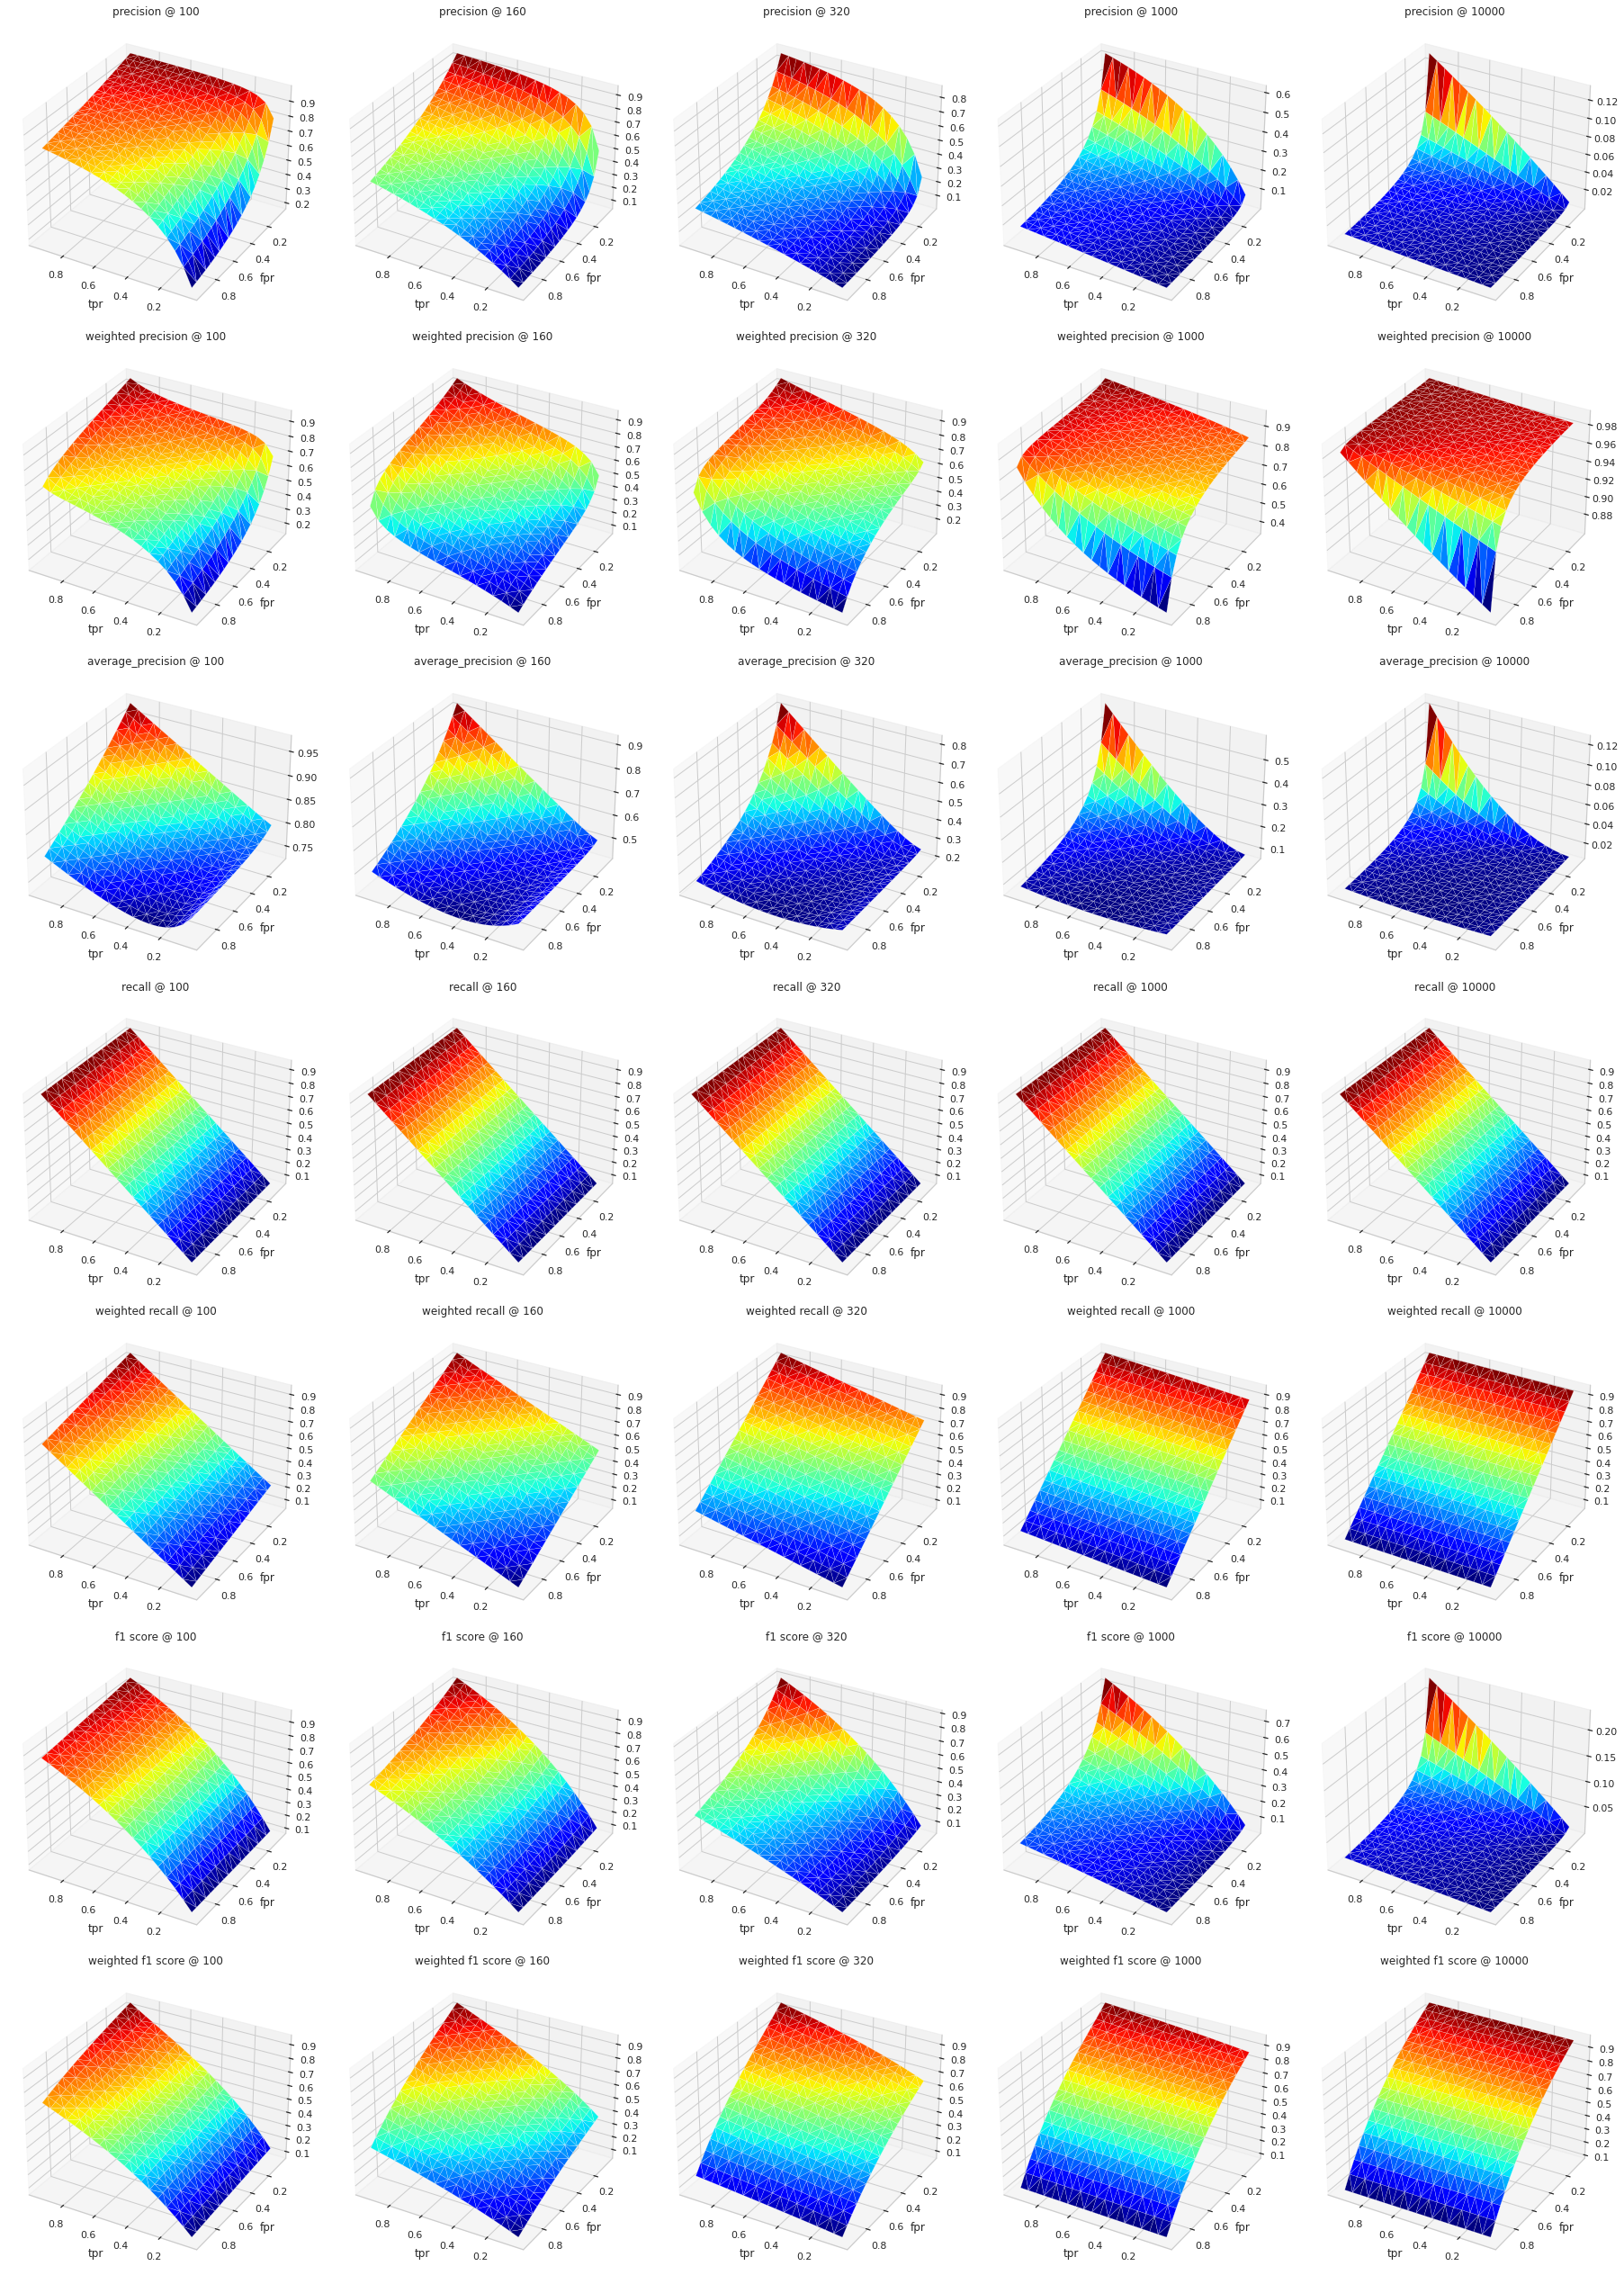

In [358]:
#poplation_sizes = [10, 50, 100, 1000, 10000]
poplation_sizes = [100, 160, 160*2, 1000, 10000]
true_positives = 80
fig2 = plt.figure(constrained_layout=True, figsize=(5*len(poplation_sizes), 5*len(metrics_to_track)))
spec2 = gridspec.GridSpec(nrows=len(metrics_to_track), ncols=len(poplation_sizes), figure=fig2)

for i, population_size in enumerate(poplation_sizes):
    tps = true_positives
    pop = population_size
    y_true =[1] * tps + [0] * (pop - tps)
    metrics_data = np.array(build_grid(y_true))
    metrics_data_pdf = pd.DataFrame(metrics_data, columns = ['tpr', 'fpr'] + [metric_name for metric_name, _ in metrics_to_track])
    for j, (metric_name, _) in enumerate(metrics_to_track):
        ax = fig2.add_subplot(spec2[j, i], projection='3d')
        rotation = (30, 120)
        plot_metric_chart(ax, metric_name, population_size, metrics_data_pdf, rotation=rotation)

filename='metrics-at-different-population-sizes-trues-are-80.png'
fig2.savefig(filename, dpi=96)

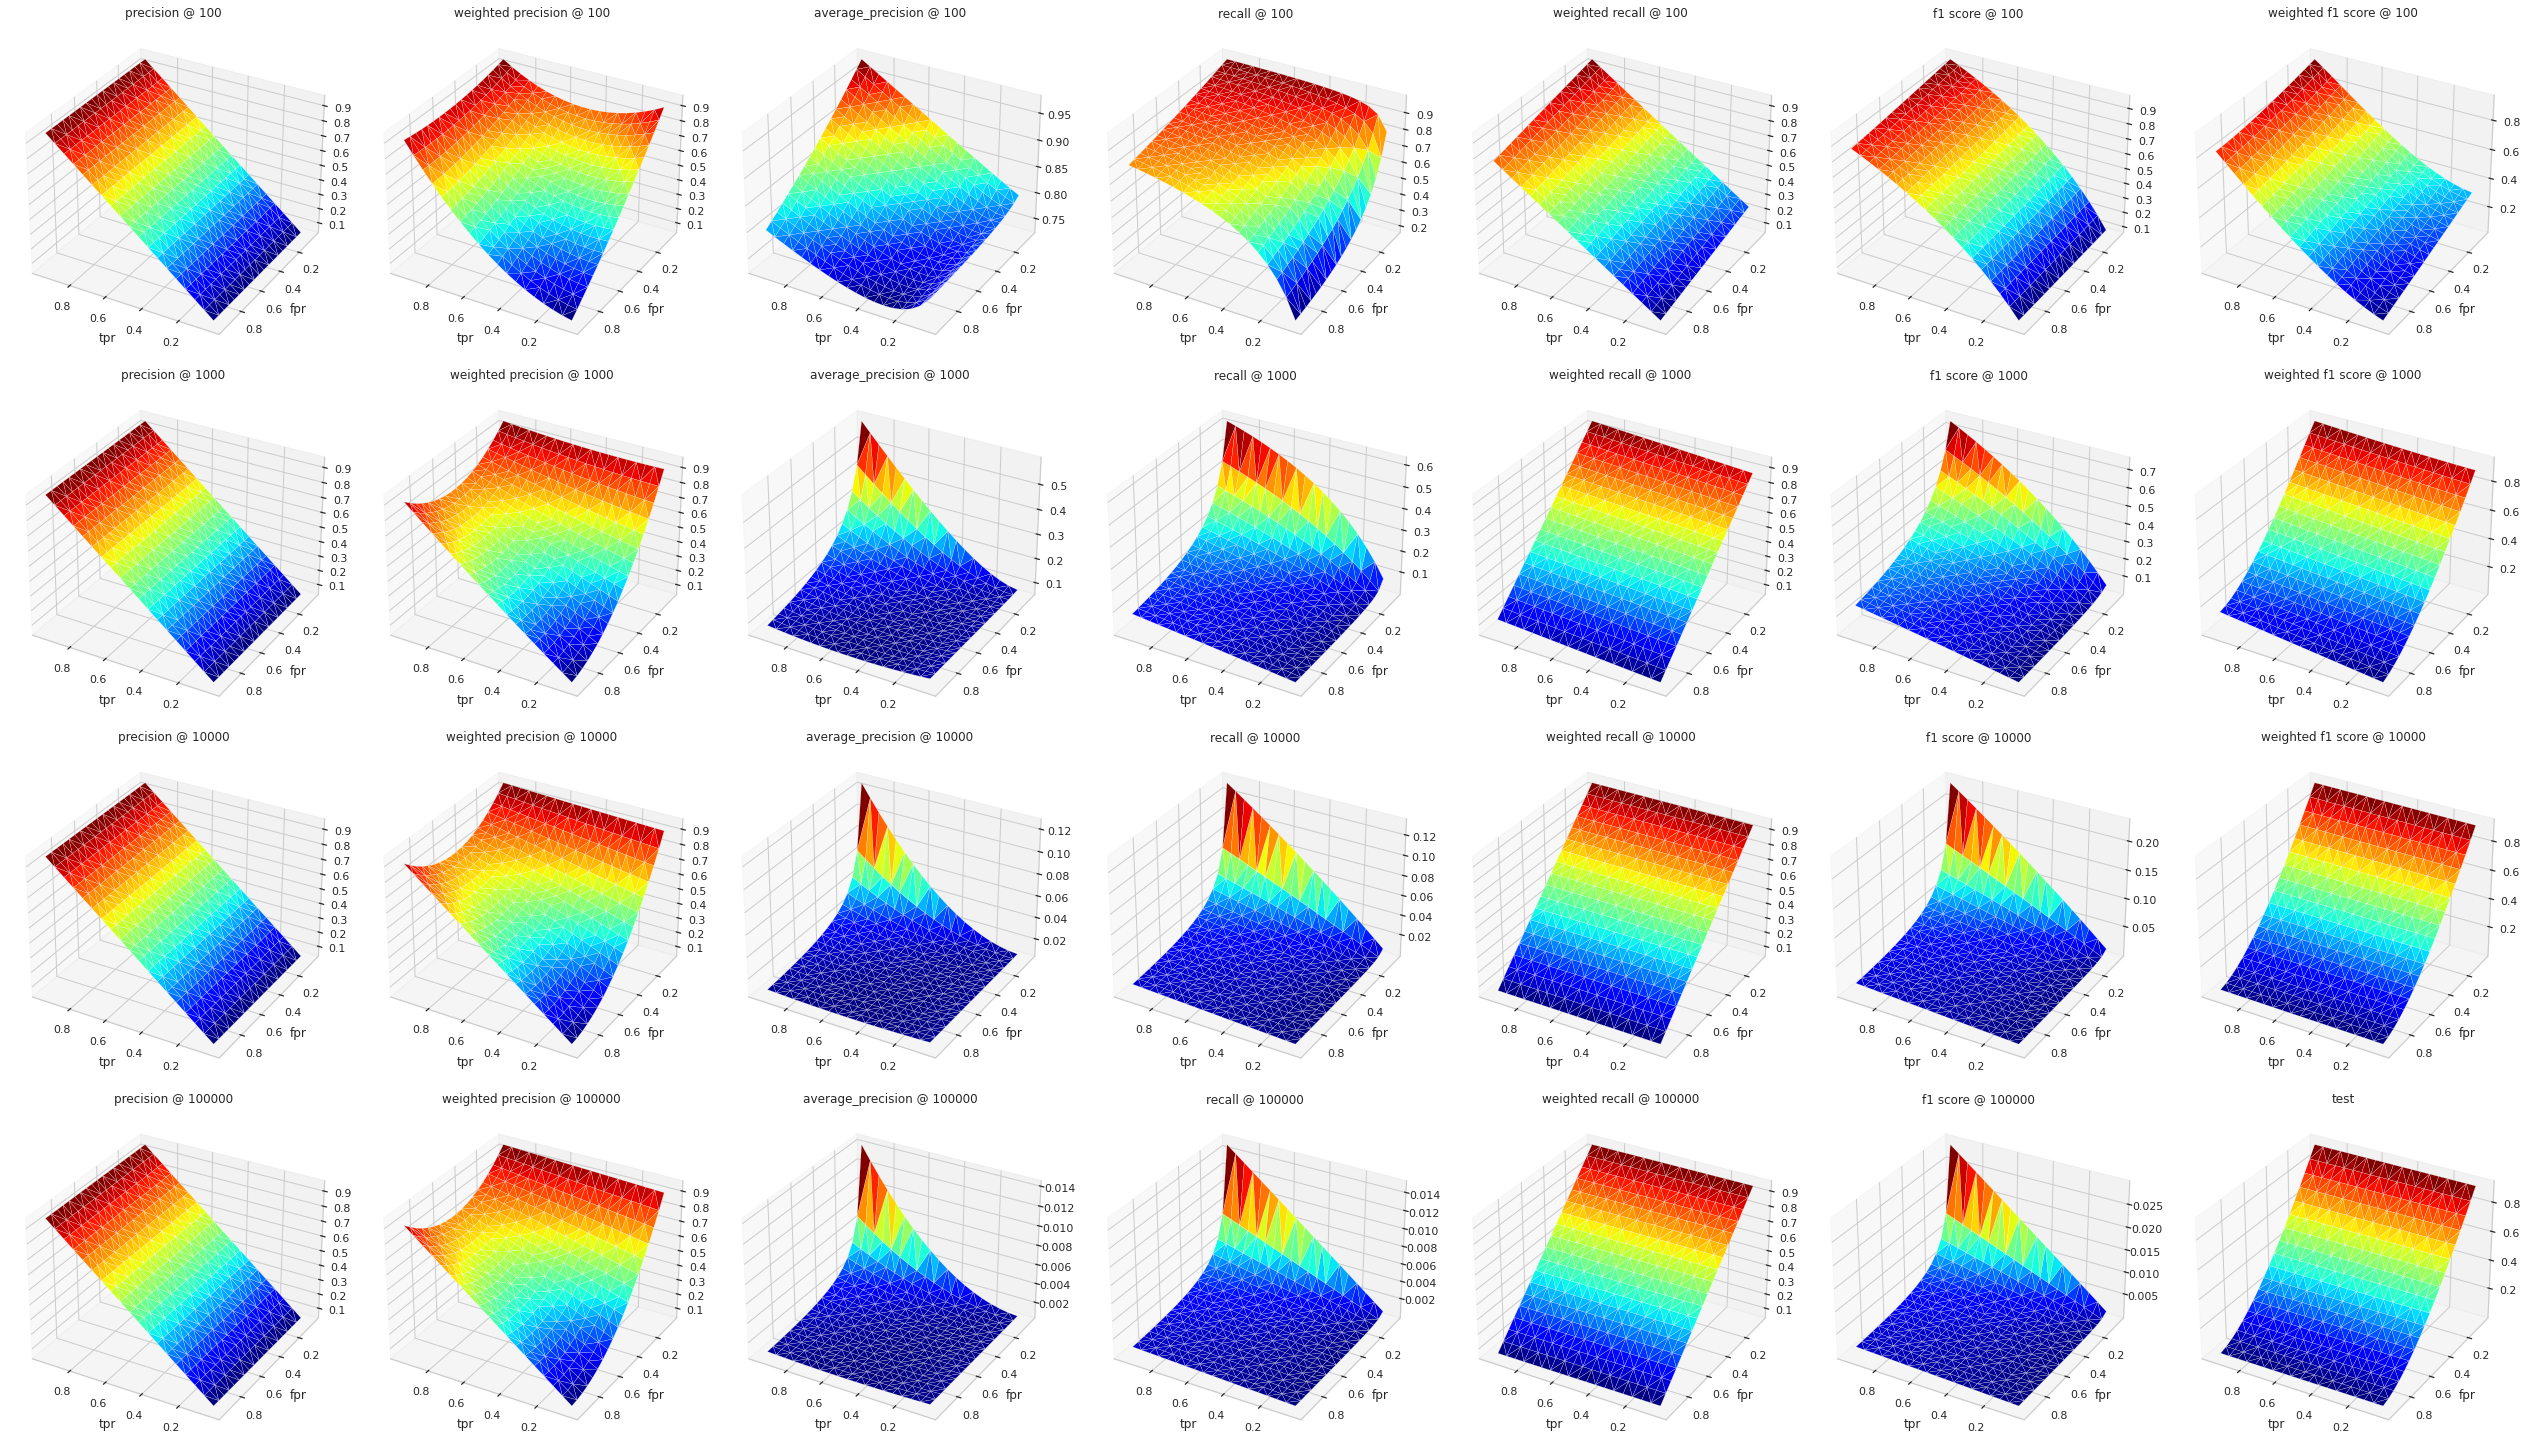

In [349]:
fig2.gca().set_title("test")
fig2

In [268]:
build_grid(y_true)

[]